## This file trains the final model we chose from cross validation and saves the trained model as a Json file. 

In [30]:
import numpy as np
from model_functions import *
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import mne
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

First we load the precalculated relative band powers of all subjects. Then we remove the test set. We calculated this data in the "very_long_epoch_performance" notebook. 

In [2]:
subject_data, freqs, targets = load_psds('all_psds_very_long.pickle')
test_labels = align_test_labels(classes=['A','C'])
features, targets = remove_class(subject_data,targets,'F')
features, targets = remove_test(features,targets,test_labels)
rbps = [relative_band_power(features[i],freqs,freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0]) 
        for i in range(len(features))]
rbps = remove_channel(rbps, ['F3','F4', 'C4', 'F8'])

In [3]:
train_X, train_y = train_prep(rbps,targets,flatten_final=True)

svc_pipe = Pipeline([('scale', StandardScaler()),
                    ('svc', SVC(C = 1.2, kernel= 'linear') )])
svc_pipe.fit(train_X, train_y)


Pipeline(steps=[('scale', StandardScaler()),
                ('svc', SVC(C=1.2, kernel='linear'))])

## Plotting coefficients of support vector classifier to get feature importances 

In [40]:
freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0]
# returns channel index and band index from the flattened index. 
def unroll(index):
    return index % len(CHANNELS), index // len(CHANNELS)
svc_coefficients = np.abs(svc_pipe['svc'].coef_).tolist()[0]
svc_feature_names = []
for i in range(len(svc_coefficients)):
    channel, band = unroll(i)
    svc_feature_names += [[CHANNELS[channel], str(freq_bands[band]) + '-' + str(freq_bands[band + 1]) + 'Hz']]
imp,names = zip(*sorted(zip(svc_coefficients, svc_feature_names)))

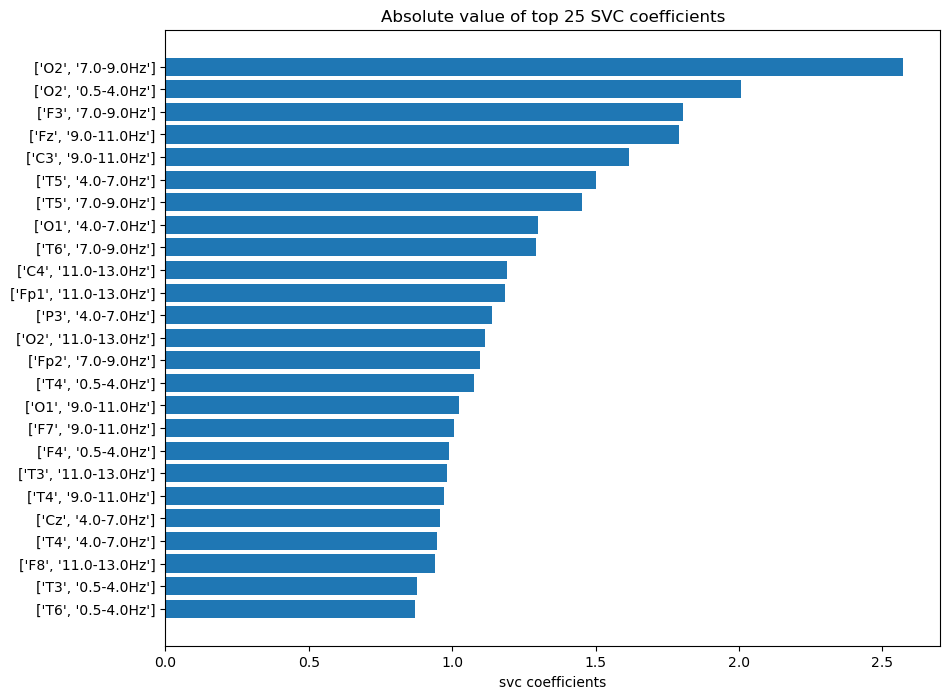

In [45]:
plt.figure(figsize = (10, 8))
plt.barh(range(25),imp[-25:] , align='center')
plt.yticks(range(25), names[-25:])
plt.xlabel('svc coefficients')
plt.title("Absolute value of top 25 SVC coefficients")
plt.show()

## Evaluating performance on the test set 

In [4]:
subject_data, freqs, targets = load_psds('all_psds_very_long.pickle')
test_labels = align_test_labels(classes=['A','C'])
features, targets = remove_class(subject_data,targets,'F')
features, targets = select_test(features,targets,test_labels)
rbps = [relative_band_power(features[i],freqs,freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0]) 
        for i in range(len(features))]
rbps = remove_channel(rbps, ['F3','F4', 'C4', 'F8'])

In [5]:
test_X, test_y = train_prep(rbps,targets,flatten_final=True)
test_pred = svc_pipe.predict(test_X)
test_confusion = confusion_matrix(test_y, test_pred)

In [6]:
test_metrics_dict = {'acc':accuracy(test_confusion), 'sens':sensitivity(test_confusion), 
                            'spec':specificity(test_confusion), 'f1':f1(test_confusion)}
print(test_metrics_dict)

{'acc': 0.8111111111111111, 'sens': 0.8888888888888888, 'spec': 0.6944444444444444, 'f1': 0.8495575221238938}


In [7]:
len(features)

8

## Saving the final model
The following code will save the above pipeline as a json file. This is useful for the app that we build from it.  

In [9]:
import json
import pickle

In [10]:

model = pickle.dumps(svc_pipe).decode('latin1')
with open('svc_classifier_AD.json', 'w') as file:
    json.dump(model, file)

The following code demonstrates how to load the model from the json file and make predictions on a test example. 

In [11]:
with open('svc_classifier_AD.json', 'r') as file:
    model_data = json.load(file)
    loaded_model = pickle.loads(model_data.encode('latin1'))
    

In [12]:
raw  = load_subject(38)
epochs = mne.make_fixed_length_epochs(raw,duration=120,preload=True,overlap=60,verbose=False)
epochs_psd = epochs.compute_psd(method='welch', fmin=0.5,fmax=45,
                                n_fft=int(4*raw.info['sfreq']),verbose=False)
epochs_psd_array, freqs = epochs_psd.get_data(return_freqs=True)
test_X = relative_band_power(epochs_psd_array, freqs,freq_bands=[0.5,4.0,7.0,9.0,11.0,13.0,25.0])
test_X = remove_channel([test_X], ['F3','F4', 'C4', 'F8'])
test_X, dummy = train_prep(test_X,[0],flatten_final=True)
pred = loaded_model.predict(test_X)

In [13]:
pred_mean = str(round(np.mean(pred, axis = 0),2))
pred_mean

'0.0'